# Validating database statistics on DDA and DIA data

In [2]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge

## Intro:

When users come to Phosphopedia, they are less concerned about how the information in the database matches to our the files that we analyzed, and more interested about their own runs. Thus, we need to do validation on runs that were not analyzed by our pipeline. One paper that is good for this is the one that describe Thesaurus, which contains both phospho-DIA samples and phospho-DDA samples that were not included in Phosphopedia. This is great since it gives us a test bed to determine how to apply our data to a new run and how the data matches up.

## Initial cross validation with DDA data

In [3]:
conn = sqlite3.connect("data/builds/human_phospho/update_20210902/phosphopedia.db")
peptides = pd.read_sql("SELECT * FROM peptide", conn)

In [4]:
def load_dda_results(dataset, sample_name):
    scan_info = pd.read_csv(os.path.join("analysis",
                                         "phosphopedia_validation",
                                         "samples",
                                         dataset,
                                         sample_name,
                                         sample_name) + ".scan_info.tsv",
                            sep="\t")
    
    percolator_results = pd.read_csv(os.path.join("analysis",
                                                  "phosphopedia_validation",
                                                  "dda_analysis",
                                                  dataset,
                                                  sample_name,
                                                  sample_name) + ".percolator.target.peptides.txt",
                                     sep="\t")
    percolator_results = percolator_results[percolator_results["percolator q-value"] < 0.01]
    
    ascore_results = pd.read_csv(os.path.join("analysis",
                                              "phosphopedia_validation",
                                              "dda_analysis",
                                               dataset,
                                               sample_name,
                                               sample_name) + ".ascore.target.txt",
                                sep="\t")
    
    merged_results = percolator_results.join(ascore_results.set_index("Scan"),
                                             how="inner",
                                             on="scan")\
                                       .join(scan_info.set_index("scan").rt,
                                             on="scan")\
                                       .loc[:,["LocalizedSequence",
                                               "scan",
                                               "rt",
                                               "charge",
                                               "percolator q-value",
                                               "Ascores"]]
    
    merged_results.columns = ["sequence", "scan", "rt", "charge", "qvalue", "ascore"]
    merged_results["sampleName"] = sample_name
    
    return merged_results

In [5]:
dda_files = ["20170430_HeLa_phosp_DDA_B_01_170506194651",
             "20170430_HeLa_phosp_DDA_B_02_170507002341",
             "20170430_HeLa_phosp_DDA_B_03_170507050032"]
dda_data = [load_dda_results("MSV000082956", f) for f in dda_files]

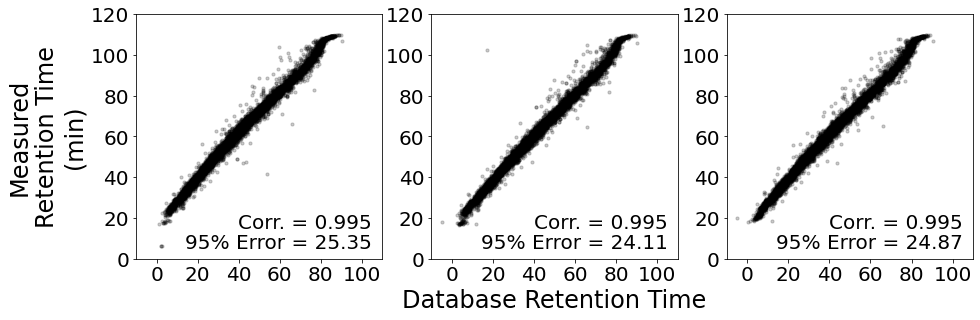

In [6]:
fig, axes = plt.subplots(figsize=(15, 4.5), ncols=3)

for ax, d in zip(axes, dda_data):
    matched_peptides = d.loc[:, ["sequence", "rt"]]\
                        .join(peptides.set_index("sequence").iRT,
                              how="inner",
                              on="sequence")
    ax.scatter(matched_peptides.iRT, 
               matched_peptides.rt,
               s=10, 
               alpha=.2,
               c="black")
    
    corr = np.corrcoef(matched_peptides.iRT.values,
                       matched_peptides.rt.values)[0, 1]
    ax.text(x=105, y=15,
            s="Corr. = %.3f" % corr,
            size=20,
            ha="right")
    
    error = np.quantile(
        np.abs(matched_peptides.iRT.values - matched_peptides.rt.values),
        .95
    )
    ax.text(x=105, y=5,
            s="95%% Error = %.2f" % error,
            size=20,
            ha="right")
    
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.set_xlim(-10, 110)
    
    ax.set_yticks([0, 20, 40, 60, 80, 100, 120])
    ax.set_ylim(0, 120)
    ax.tick_params(labelsize=20)

    
axes[0].set_ylabel("Measured\nRetention Time\n(min)",
                   size=24)
axes[1].set_xlabel("Database Retention Time",
                   size=24)
plt.show()

Each of these curves is fairly linear, implying that the gradient used in the paper is similar to the one learned within the peptide information in Phosphopedia. If using large amounts of peptides, we could likely do an extremely fine tuned recalibration that captured the structure near the end of the gradient. However, we want to get a notion of what will occur with a small calibration set, so we will go ahead with a linear model.

In [7]:
def direct_scale(X, y, X_valid):
    scale_down = StandardScaler()
    scale_down.fit(X.reshape(-1, 1))
    scale_up = StandardScaler()
    scale_up = scale_up.fit(y.reshape(-1, 1))

    return scale_up.inverse_transform(scale_down.transform(X_valid.reshape(-1, 1)))

def get_error_quantiles(test, test_pred, q=None):
    if q is None:
        q = np.linspace(0, 1, num=21)

    abs_errors = np.abs(test - test_pred)
    df = pd.DataFrame({"quantiles" : q,
                       "values" : np.quantile(abs_errors, q)})
    
    return df

def run_test(X, y, learning_function):
    folds = KFold(n_splits=10,
                  shuffle=True, 
                  random_state=98115)
    df_list = []
    size_list = [25, 50, 100, 250, 500, 1000]
    for split, (train_ind, test_ind) in enumerate(folds.split(X)):
        for size in size_list:
            test_pred = learning_function(X[train_ind[:size]],
                                          y[train_ind[:size]],
                                          X[test_ind])
            
            df = get_error_quantiles(y[test_ind].flatten(), test_pred.flatten())
            df["split"] = split
            df["train_size"] = size
            df_list.append(df)

    return pd.concat(df_list)

In [8]:
linear_results = []
for ind, d in enumerate(dda_data):
    matched_peptides = d.loc[:, ["sequence", "rt"]]\
                        .join(peptides.set_index("sequence").iRT,
                              how="inner",
                              on="sequence")
    
    linear_results.append(run_test(matched_peptides.iRT.values, 
                                   matched_peptides.rt.values, 
                                   direct_scale))
    linear_results[-1]["dataset"] = "DDA%i" % (ind + 1)
    
linear_results = pd.concat(linear_results)

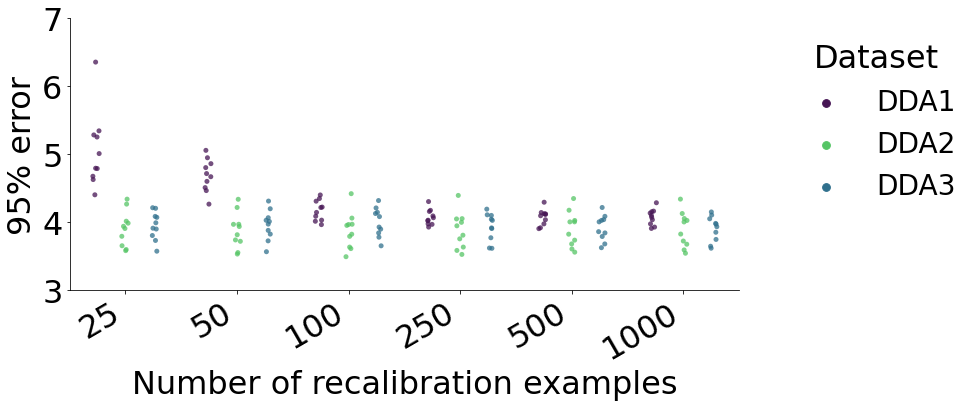

In [9]:
fig = plt.figure(figsize=(12, 5))

select = np.isclose(linear_results.quantiles, 0.95)
sns.stripplot(data=linear_results[select],
              x="train_size",
              y="values",
              hue="dataset",
              palette=["#461554", "#56c566", "#30708d"],
              alpha=.75,
              dodge=True)

plt.ylim(3, 7)
plt.tick_params(labelsize=32)
plt.xticks(rotation=30, ha="right")
plt.yticks([3, 4, 5, 6, 7])
plt.xlabel("Number of recalibration examples", size=32)
plt.ylabel("95% error", size=32)
plt.legend(title="Dataset", 
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           frameon=False,
           fontsize=28,
           title_fontsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/thesaurus_paper_recalibration_cv.svg")
plt.show()

For two of the samples it appears there is no real issue with using any number of calibration peptides for transfering the model. Interestingly though, one sample seems to have a lot of trouble with calibration for no obvious reason. The last scatter plot looks roughly the same accross runs, so I am not sure where the problem may lie. In all though, there seems to be very little problem with calibration here.

In [10]:
select = np.logical_and(linear_results.train_size == 25,
                        np.isclose(linear_results.quantiles, 0.95))
linear_results[select].groupby(["dataset", "quantiles"])\
                      .apply(lambda df: pd.Series({"mean" : df["values"].mean(), 
                                                   "sd": df["values"].std()}))

,,mean,sd
dataset,quantiles,,
DDA1,0.95,5.054710,0.553884
DDA2,0.95,3.908669,0.261161
DDA3,0.95,3.949396,0.206460


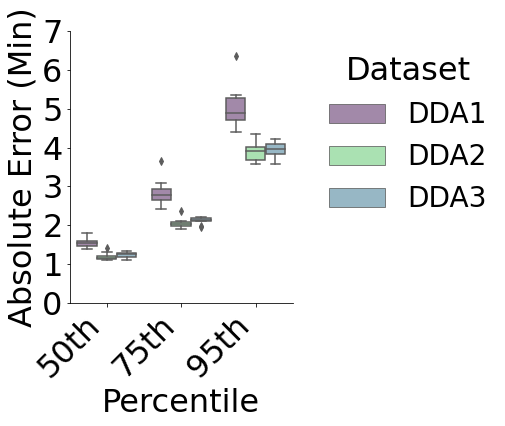

In [11]:
fig = plt.figure(figsize=(4, 5))

selected_quantiles = [.5, .75, .95]
select = np.any(np.isclose(linear_results.quantiles.values.reshape(-1, 1), 
                           selected_quantiles),
                axis=1)
select = np.logical_and(select, linear_results.train_size == 25)

filtered_results = linear_results[select].copy()

sns.boxplot(x="quantiles",
            y="values",
            hue="dataset",
            data=filtered_results,
            palette=["#a289a9", "#aae1b2", "#97b7c5"],
            saturation=1)

plt.ylim(0, 7)
plt.tick_params(labelsize=32)
plt.xticks([0, 1, 2], ["50th", "75th", "95th"],
           rotation=45, ha="right")
plt.yticks(np.arange(8))
plt.xlabel("Percentile", size=32)
plt.ylabel("Absolute Error (Min)", size=32)
plt.legend(title="Dataset", 
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           frameon=False,
           fontsize=28,
           title_fontsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/thesaurus_paper_recalibration_25_peptide_quantiles.svg")
plt.show()

The above plot gives a slightly different perspective on the cross validation errors by looking at different quantiles for the 25 peptide recalibration cross validation. For the worst case scenario, where individuals supply only a handful of peptides, they can still expect fairly good performance.

## Evaluation on direct DIA analysis

The evaluation that I will perform in this section is in many repsects retrospective. We analyzed some phospho-DIA data using the directDIA method of Spectronaut. This allows the data to be independent of the identifications in Phosphopedia. The question is, given that we used the location data within Phosphopedia to build an assay, how often would Spectronaut agree that there was something there to be analyzed?

In [12]:
dia_data = pd.read_table(os.path.join("analysis",
                                      "phosphopedia_validation",
                                      "dia_analysis",
                                      "MSV000082956",
                                      "20210930_154651_Phosphopedia_human_validation.csv"))

dia_files = ["20170430_HeLa_phosp_DIA_B_01_170506220515",
             "20170430_HeLa_phosp_DIA_B_02_170507024206",
             "20170430_HeLa_phosp_DIA_B_03_170507071858"]
dia_data = [dia_data[dia_data["R.FileName"] == f] for f in dia_files]    

In [13]:
def transform_dia_data(df):
    selected_columns = ["R.FileName", "EG.ModifiedPeptide",
                        "EG.PEP", "EG.Qvalue",
                        "EG.ApexRT", "FG.Charge",
                        "FG.MS2RawQuantity"]
    df = df[selected_columns].sort_values("EG.PEP")\
                             .drop_duplicates("EG.ModifiedPeptide")
    df.columns = ["sampleName", "sequence", "pep",
                  "qvalue", "rt", "charge",
                  "intensity"]
    df.sequence = df.sequence.str.replace("_", "",
                                          regex=True)
    df.sequence = df.sequence.str.replace("\[Acetyl \(Protein N-term\)\]", "n[42]", 
                                          regex=True)
    df.sequence = df.sequence.str.replace("\[Phospho \(STY\)\]", "[80]", 
                                          regex=True)
    df.sequence = df.sequence.str.replace("\[Oxidation \(M\)\]", "[16]",
                                          regex=True)
    df.sequence = df.sequence.str.replace("\[Carbamidomethyl \(C\)\]", "[57]",
                                          regex=True)

    return df

dia_data = pd.read_table(os.path.join("analysis",
                                      "phosphopedia_validation",
                                      "dia_analysis",
                                      "MSV000082956",
                                      "20210930_154651_Phosphopedia_human_validation.csv"))

dia_files = ["20170430_HeLa_phosp_DIA_B_01_170506220515",
             "20170430_HeLa_phosp_DIA_B_02_170507024206",
             "20170430_HeLa_phosp_DIA_B_03_170507071858"]
dia_data = [transform_dia_data(dia_data[dia_data["R.FileName"] == f]) for f in dia_files]    

In [16]:
count_df = []
for ind, df in enumerate(dda_data, 1):
    count_df.append(
        pd.Series({"Type" : "DDA",
                   "File" : "DDA" + str(ind),
                   "Total" : df.sequence.unique().shape[0],
                   "Overlap" : np.intersect1d(df.sequence, peptides.sequence).shape[0]})
    )
    
for ind, df in enumerate(dia_data, 1):
    count_df.append(
        pd.Series({"Type" : "DIA",
                   "File" : "DIA" + str(ind),
                   "Total" : df.sequence.unique().shape[0],
                   "Overlap" : np.intersect1d(df.sequence, peptides.sequence).shape[0]})
    )
    
count_df = pd.concat(count_df, axis=1).T
count_df = count_df.melt(id_vars=["File", "Type"], 
                         value_vars=["Total", "Overlap"],
                         value_name="Count",
                         var_name="countType")
count_df.sort_values(["Type", "countType", "File"])

,File,Type,countType,Count
6,DDA1,DDA,Overlap,7876
7,DDA2,DDA,Overlap,7858
8,DDA3,DDA,Overlap,8007
0,DDA1,DDA,Total,8095
1,DDA2,DDA,Total,8066
2,DDA3,DDA,Total,8238
9,DIA1,DIA,Overlap,9334
10,DIA2,DIA,Overlap,9372
11,DIA3,DIA,Overlap,9380
3,DIA1,DIA,Total,13280


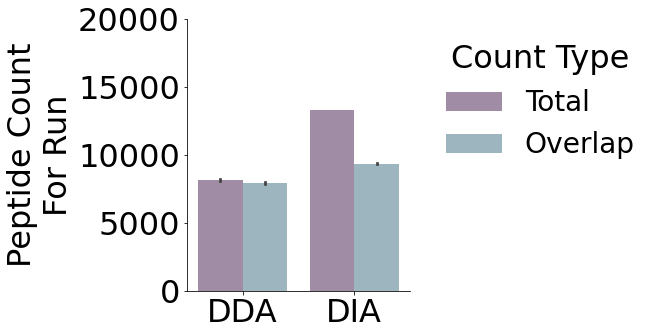

In [17]:
fig = plt.figure(figsize=(4, 5))

sns.barplot(x="Type",
            y="Count",
            data = count_df,
            hue="countType",
            palette=["#a289a9", "#97b7c5"])

plt.ylim(0, 20000)
plt.tick_params(labelsize=32)
plt.xlabel("", size=32)
plt.ylabel("Peptide Count\nFor Run", size=32)
plt.legend(title="Count Type",
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           frameon=False,
           fontsize=28,
           title_fontsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/thesaurus_paper_detected_peptide_count.svg")
plt.show()

When using the database detections for predictions, we really only have the ability to deal with situations where we want to know about peptides in the database. Thus, we need to restrict our analyses down to only look at phosphopeptides which overlap between the directDIA method and the database. It is extremely interesting to see that the DDA analysis has almost 100% overlap, which really shows our saturation in detections for the DDA level.

### RT Evaluation

In [77]:
dia_rt_values = []
for d in dia_data:
    selected_columns = ["R.FileName", "EG.ModifiedPeptide",
                        "EG.PEP", "EG.Qvalue",
                        "EG.ApexRT", "FG.Charge"]
    d = d[selected_columns].sort_values("EG.PEP")\
                           .drop_duplicates("EG.ModifiedPeptide")
    d.columns = ["sampleName", "sequence", "pep",
                 "qvalue", "rt", "charge"]
    d.sequence = d.sequence.str.replace("_", "",
                                        regex=True)
    d.sequence = d.sequence.str.replace("\[Acetyl \(Protein N-term\)\]", "n[42]", 
                                        regex=True)
    d.sequence = d.sequence.str.replace("\[Phospho \(STY\)\]", "[80]", 
                                        regex=True)
    d.sequence = d.sequence.str.replace("\[Oxidation \(M\)\]", "[16]",
                                        regex=True)
    d.sequence = d.sequence.str.replace("\[Carbamidomethyl \(C\)\]", "[57]",
                                        regex=True)

    dia_rt_values.append(d[["sampleName", "sequence", "rt"]])

In [88]:
dia_rt_values = [df[["sampleName", "sequence", "rt"]] for df in dia_data]

results = []
for ind, (dda_df, dia_df) in enumerate(zip(dda_data, dia_rt_values)):
    # Build calibration set
    all_cal_peptides = dda_df.loc[:, ["sequence", "rt"]]\
                             .join(peptides.set_index("sequence").iRT,
                                   how="inner",
                                   on="sequence")
    print("Calibration on: " + dda_df.sampleName.values[0])
    print("\tTotal peptides in calibration sample: {}".format(dda_df.shape[0]))
    print("\tPossible calibration peptides: {}".format(all_cal_peptides.shape[0]))
    
    # Build prediction set
    all_pred_peptides = dia_df.loc[:, ["sequence", "rt"]]\
                              .join(peptides.set_index("sequence").iRT,
                                    how="inner",
                                    on="sequence")
    print("Predicting on: " + dia_df.sampleName.values[0])
    print("\tTotal peptides in prediction sample: {}".format(dia_df.shape[0]))
    print("\tPossible prediction peptides: {}".format(all_pred_peptides.shape[0]))
    
    np.random.seed(98115)
    for trial in range(10):
        cal_peptides = all_cal_peptides.sample(25)
        calibrated_irt = direct_scale(cal_peptides.iRT.values,
                                      cal_peptides.rt.values,
                                      all_pred_peptides.iRT.values)
        
        trial_results = pd.DataFrame({"pep_ind": np.arange(all_pred_peptides.shape[0]),
                                      "rt": all_pred_peptides.rt.values,
                                      "pred_rt": calibrated_irt.flatten()})
        trial_results["delta_rt"] = trial_results.rt - trial_results.pred_rt
        trial_results["abs_delta_rt"] = trial_results.delta_rt.abs()
        trial_results["sample_name"] = "DIA{}".format(ind + 1)
        trial_results["trial"] = trial
        results.append(trial_results)
        
    print("\n")

results = pd.concat(results)

Calibration on: 20170430_HeLa_phosp_DDA_B_01_170506194651
	Total peptides in calibration sample: 8485
	Possible calibration peptides: 8264
Predicting on: 20170430_HeLa_phosp_DIA_B_01_170506220515
	Total peptides in prediction sample: 13280
	Possible prediction peptides: 9334


Calibration on: 20170430_HeLa_phosp_DDA_B_02_170507002341
	Total peptides in calibration sample: 8472
	Possible calibration peptides: 8260
Predicting on: 20170430_HeLa_phosp_DIA_B_02_170507024206
	Total peptides in prediction sample: 13311
	Possible prediction peptides: 9372


Calibration on: 20170430_HeLa_phosp_DDA_B_03_170507050032
	Total peptides in calibration sample: 8649
	Possible calibration peptides: 8413
Predicting on: 20170430_HeLa_phosp_DIA_B_03_170507071858
	Total peptides in prediction sample: 13306
	Possible prediction peptides: 9380




In [89]:
total = results.groupby(["sample_name", "trial"])\
               .abs_delta_rt\
               .count()\
               .rename("ntotal")\
               .to_frame()

counts_by_cutoff = []
for cutoff in np.linspace(.5, 6, 12):
    filtered_results = results[results.abs_delta_rt <= cutoff]
    counts = filtered_results.groupby(["sample_name", "trial"])\
                             .abs_delta_rt\
                             .count()\
                             .rename("npeptides")\
                             .to_frame()
    counts = counts.join(total)
    counts["proportion"] = counts.npeptides/counts.ntotal
    counts["cutoff"] = cutoff
    counts_by_cutoff.append(counts.reset_index())
    
counts_by_cutoff = pd.concat(counts_by_cutoff)

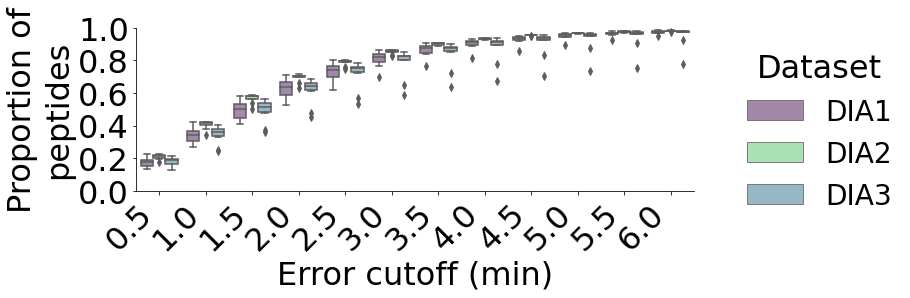

In [90]:
fig = plt.figure(figsize=[10, 3])

sns.boxplot(x="cutoff",
            y="proportion",
            hue="sample_name",
            data=counts_by_cutoff,
            palette=["#a289a9", "#aae1b2", "#97b7c5"],
            saturation=1)

plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 6))
plt.xticks(rotation=45, ha="right")
plt.tick_params(labelsize=32)
plt.xlabel("Error cutoff (min)", size=32)
plt.ylabel("Proportion of\npeptides", size=32)
plt.legend(title="Dataset", 
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           frameon=False,
           fontsize=28,
           title_fontsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/human_peptide_rt_recovery_dia.svg",
            bbox_inches="tight")
plt.show()

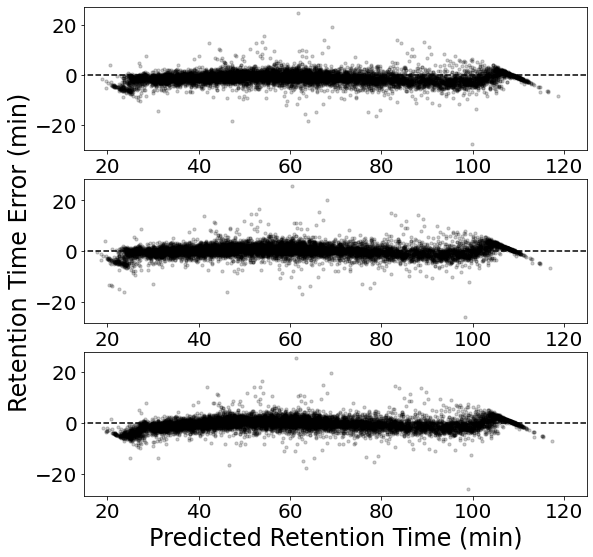

In [103]:
fig, axes = plt.subplots(figsize=(9, 9), nrows=3)

for ax, name in zip(axes, results.sample_name.unique()):
    ax.plot([0, 140],
            [0, 0],
            linestyle="--",
            color="black")
    
    select = results.sample_name == name
    ax.scatter(x="pred_rt",
               y="delta_rt",
               data=results[select].groupby("pep_ind").median(),
               s=10, 
               alpha=.2,
               c="black")
    
    ax.tick_params(labelsize=20)
    ax.set_xlim(15, 125)

    
axes[1].set_ylabel("Retention Time Error (min)",
                   size=24)
axes[2].set_xlabel("Predicted Retention Time (min)",
                   size=24)
plt.show()

For retention time, we calibrate the values in Phosphopedia to a DDA run that occured right before the DIA run and look to see how well the retention times match up. This seems to work quite well, with most peaks in the DIA data occuring within 3 minutes of where Phosphopedia says they should be and almost all peaks occuring within 5 minutes.

### Charge Evaluation

In [26]:
dia_charge_values = []
for d in dia_data:
    selected_columns = ["R.FileName", "EG.ModifiedPeptide",
                        "EG.PEP", "EG.Qvalue",
                        "FG.Charge", "FG.MS2RawQuantity"]
    d = d[selected_columns].sort_values("EG.PEP")\
                           .drop_duplicates(["EG.ModifiedPeptide", "FG.Charge"])
    d.columns = ["sampleName", "sequence", "pep",
                 "qvalue", "charge", "intensity"]
    d.sequence = d.sequence.str.replace("_", "",
                                        regex=True)
    d.sequence = d.sequence.str.replace("\[Acetyl \(Protein N-term\)\]", "n[42]",
                                        regex=True)
    d.sequence = d.sequence.str.replace("\[Phospho \(STY\)\]", "[80]",
                                        regex=True)
    d.sequence = d.sequence.str.replace("\[Oxidation \(M\)\]", "[16]",
                                        regex=True)
    d.sequence = d.sequence.str.replace("\[Carbamidomethyl \(C\)\]", "[57]",
                                        regex=True)

    dia_charge_values.append(d[["sampleName", "sequence", "charge", "intensity"]])

In [27]:
charge_state_count = pd.concat(dia_charge_values).groupby(["sampleName", "sequence"])\
                                                 .charge.count()\
                                                 .rename("chargeStates")
charge_state_count.reset_index().groupby(["sampleName", "chargeStates"]).count()

sequence
sampleName                                chargeStates          
20170430_HeLa_phosp_DIA_B_01_170506220515 1                12159
                                          2                 1114
                                          3                    7
20170430_HeLa_phosp_DIA_B_02_170507024206 1                12190
                                          2                 1114
                                          3                    7
20170430_HeLa_phosp_DIA_B_03_170507071858 1                12184
                                          2                 1115
                                          3                    7

In [28]:
peptide_charge_counts = peptides[["sequence", "z2", "z3", "z4", "z5", "z6"]].melt(id_vars=["sequence"],
                                                                                  var_name="charge", 
                                                                                  value_name="psms")
peptide_charge_counts.charge = peptide_charge_counts.charge.str.replace("z", "").astype(int)
peptide_charge_counts.sort_values("psms", ascending=False, inplace=True)
peptide_charge_counts["chargeRank"] = peptide_charge_counts.groupby("sequence")\
                                                           .psms\
                                                           .rank(ascending=False, method="first")\
                                                           .astype(int)
peptide_charge_counts = peptide_charge_counts[peptide_charge_counts.psms > 5]

In [30]:
dia_charge_ranked = pd.concat(dia_charge_values).join(peptide_charge_counts.set_index(["sequence", "charge"])\
                                                                           [["psms", "chargeRank"]],
                                                      on=["sequence", "charge"],
                                                      how="inner")

In [31]:
rank_1_peptides = dia_charge_ranked[dia_charge_ranked.chargeRank == 1].groupby("sampleName")\
                                                                      .sequence\
                                                                      .count()\
                                                                      .rename("pepCount")\
                                                                      .reset_index()
rank_1_peptides["group"] = "Top 1"

rank_2_peptides = dia_charge_ranked[dia_charge_ranked.chargeRank <= 2].drop_duplicates(["sampleName", "sequence"])\
                                                                      .groupby("sampleName")\
                                                                      .sequence\
                                                                      .count()\
                                                                      .rename("pepCount")\
                                                                      .reset_index()
rank_2_peptides["group"] = "Top 2"

overlap_peptides = dia_charge_ranked.drop_duplicates(["sampleName", "sequence"])\
                                    .groupby("sampleName")\
                                    .sequence\
                                    .count()\
                                    .rename("pepCount")\
                                    .reset_index()

overlap_peptides["group"] = "Overlap"

all_peptides = pd.concat(dia_charge_values).drop_duplicates(["sampleName", "sequence"])\
                                           .groupby("sampleName")\
                                           .sequence\
                                           .count()\
                                           .rename("pepCount")\
                                           .reset_index()

all_peptides["group"] = "All"

recovery_counts = pd.concat([rank_1_peptides,
                             rank_2_peptides,
                             overlap_peptides,
                             all_peptides])

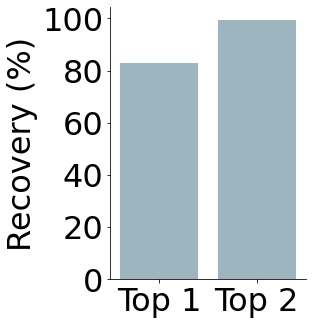

In [33]:
fig = plt.figure(figsize=(3.5, 5))

recovery_prop = recovery_counts.join(recovery_counts[recovery_counts.group=="Overlap"].set_index("sampleName")\
                                                                                       .pepCount\
                                                                                       .rename("overlapCount"),
                                     on="sampleName")
recovery_prop["recovery"] = 100*recovery_prop.pepCount/recovery_prop.overlapCount

sns.barplot(data=recovery_prop[recovery_prop.group.str.contains("Top")],
            x="group",
            y="recovery",
            color="#30708d",
            alpha=.5,
            errwidth=0)

plt.yticks([0, 20, 40, 60, 80, 100])
plt.xlabel("", size=32)
plt.ylabel("Recovery (%)", size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/human_peptide_charge_recovery_dia.svg",
            bbox_inches="tight")
plt.show()

Given the limited amount of targets that can be inserted into a run, looking at the top charge state for a peptide is the most common. It is nice to see though, that not only is the recovery for Phosphopedia's max charge state good, but we quickly shoot to 100% recovery with the top two charge states. This is what we hope to happen and gives us confidence in the spectral counts.

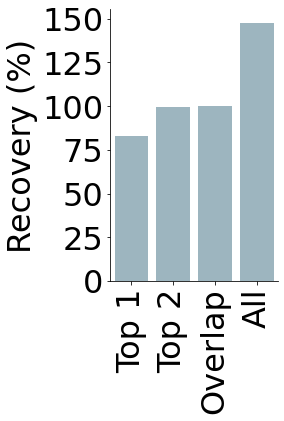

In [32]:
fig = plt.figure(figsize=(3, 5))

recovery_prop = recovery_counts.join(recovery_counts[recovery_counts.group=="Overlap"].set_index("sampleName")\
                                                                                       .pepCount\
                                                                                       .rename("overlapCount"),
                                     on="sampleName")
recovery_prop["recovery"] = 100*recovery_prop.pepCount/recovery_prop.overlapCount

sns.barplot(data=recovery_prop,
            x="group",
            y="recovery",
            color="#30708d",
            alpha=.5,
            errwidth=0)
plt.xticks(rotation=90, ha="center", va="top")
plt.yticks([0, 25, 50, 75, 100, 125, 150])
plt.xlabel("", size=32)
plt.ylabel("Recovery (%)", size=32)
plt.tick_params(labelsize=32)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.show()